In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
import torch
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from timm.data import Mixup

### 1. Загрузка и разделение данных

In [4]:
labels = pd.read_csv('data/Train.csv')

print(labels.head())
print(labels['Label'].value_counts())
print(f'Duplicated: {labels["img_IDS"].duplicated().sum()}')

train_df, valid_df = train_test_split(labels, test_size=0.33, random_state=42, stratify=labels['Label'])

            img_IDS             Label
0  ImageID_33HMDMJ3            Temple
1  ImageID_V5POEX4O            Church
2  ImageID_89CCCCW6  Enough/Satisfied
3  ImageID_GNJXOWX5                Me
4  ImageID_7Q9LOP7R              Love
Label
Enough/Satisfied    695
Mosque              695
Seat                695
Temple              694
Church              694
Me                  694
Love                694
You                 694
Friend              694
Name: count, dtype: int64
Duplicated: 0


### 2. Поиск изображений и целей

In [5]:
# https://zindi.africa/competitions/kenyan-sign-language-classification-challenge/data (Images)

class CustomDataset(Dataset):
    def __init__(self, df, transform=None, labels_idx=None):
        self.df = df
        self.transform = transform
        self.labels_idx_num = labels_idx
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Загружаем изображение
        img_path = f'data/Images/{row["img_IDS"]}.jpg'
        image = cv2.imread(img_path) 
        if image is None:
            raise FileNotFoundError(f"Файл не найден или не прочитан: {img_path}")
        image = cv2.resize(image, (128, 128))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=0)  # форма станет [1, H, W]
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # нормализация

        # Получаем метку и переводим её в индекс из словаря
        label = self.labels_idx_num[row["Label"]]
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label


labels_idx_num = {label: idx for idx, label in enumerate(labels['Label'].unique())}

train_dataset = CustomDataset(train_df, labels_idx=labels_idx_num)
valid_dataset = CustomDataset(valid_df, labels_idx=labels_idx_num)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [6]:
images, labels = train_loader.__iter__().__next__()

print(images.shape)
print(labels.shape)  
print(labels)       

torch.Size([32, 1, 128, 128])
torch.Size([32])
tensor([8, 0, 8, 6, 0, 2, 8, 8, 6, 3, 7, 0, 4, 6, 0, 7, 8, 0, 3, 4, 0, 6, 4, 6,
        5, 5, 8, 8, 2, 6, 4, 8])


### 3. Реализация LeNet

In [5]:
class LeNet(nn.Module):
    def __init__(self, num_classes=9):
        super(LeNet, self).__init__()
        
        # --- Сверточные слои ---
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)  # уменьшаем размер в 2 раза

        # --- Dropout ---
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # --- Полносвязные слои ---
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # после двух conv + pool
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # возвращаем logits, для BCEWithLogitsLoss или CrossEntropyLoss

# --- Проверка ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet(num_classes=9).to(device)
print(model)

dummy_input = torch.randn(32, 1, 128, 128).to(device)
output = model(dummy_input)
print(output.shape)  # должно быть [32, 9]

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=262144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
)
torch.Size([32, 9])


### 4. Обучение LeNet

In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Модель ---
model = LeNet(num_classes=9).to(device)

# --- Для мультиклассовой бинарной классификации ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
global_epoch = 0


def train(model, train_loader, criterion, optimizer, epoch_num):
    model.train()
    train_loss = []
    log_interval = 10

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        labels_onehot = torch.zeros(labels.size(0), 9, device=device)
        labels_onehot.scatter_(1, labels.view(-1,1), 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_onehot)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        if (i + 1) % log_interval == 0:
            print(f'Epoch {epoch_num+1}, Step {i+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}')

    avg_train_loss = sum(train_loss) / len(train_loss)
    print(f"Epoch {epoch_num+1} | Train Loss: {avg_train_loss:.4f}")
    return avg_train_loss

def validation(model, valid_loader, criterion, epoch_num):
    model.eval()
    val_loss = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels_onehot = torch.zeros(labels.size(0), 9, device=device)
            labels_onehot.scatter_(1, labels.view(-1,1), 1)

            outputs = model(images)
            loss = criterion(outputs, labels_onehot)
            val_loss.append(loss.item())

            preds = torch.sigmoid(outputs)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels_onehot.cpu().tolist())

    avg_val_loss = sum(val_loss) / len(val_loss)
    auc = roc_auc_score(all_labels, all_preds, average='macro')
    print(f"Epoch {epoch_num+1} | Validation Loss: {avg_val_loss:.4f} | AUC ROC: {auc:.4f}")
    return avg_val_loss, auc

history = {'train_loss': [], 'val_loss': [], 'auc':[]}

In [148]:
# --- Основной цикл обучения ---
epochs_to_run = 10

for epoch in range(epochs_to_run):
    train_loss = train(model, train_loader, criterion, optimizer, global_epoch)
    val_loss, auc = validation(model, valid_loader, criterion, global_epoch)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['auc'].append(auc)

    global_epoch += 1


Epoch 1, Step 10/131, Batch Loss: 0.4415
Epoch 1, Step 20/131, Batch Loss: 0.3826
Epoch 1, Step 30/131, Batch Loss: 0.3653
Epoch 1, Step 40/131, Batch Loss: 0.3686
Epoch 1, Step 50/131, Batch Loss: 0.3568
Epoch 1, Step 60/131, Batch Loss: 0.3701
Epoch 1, Step 70/131, Batch Loss: 0.3809
Epoch 1, Step 80/131, Batch Loss: 0.3598
Epoch 1, Step 90/131, Batch Loss: 0.3526
Epoch 1, Step 100/131, Batch Loss: 0.3490
Epoch 1, Step 110/131, Batch Loss: 0.3523
Epoch 1, Step 120/131, Batch Loss: 0.3662
Epoch 1, Step 130/131, Batch Loss: 0.3562
Epoch 1 | Train Loss: 0.3814
Epoch 1 | Validation Loss: 0.3542 | AUC ROC: 0.5118
Epoch 2, Step 10/131, Batch Loss: 0.3560
Epoch 2, Step 20/131, Batch Loss: 0.3533
Epoch 2, Step 30/131, Batch Loss: 0.3560
Epoch 2, Step 40/131, Batch Loss: 0.3729
Epoch 2, Step 50/131, Batch Loss: 0.3625
Epoch 2, Step 60/131, Batch Loss: 0.3549
Epoch 2, Step 70/131, Batch Loss: 0.3536
Epoch 2, Step 80/131, Batch Loss: 0.3558
Epoch 2, Step 90/131, Batch Loss: 0.3612
Epoch 2, Step

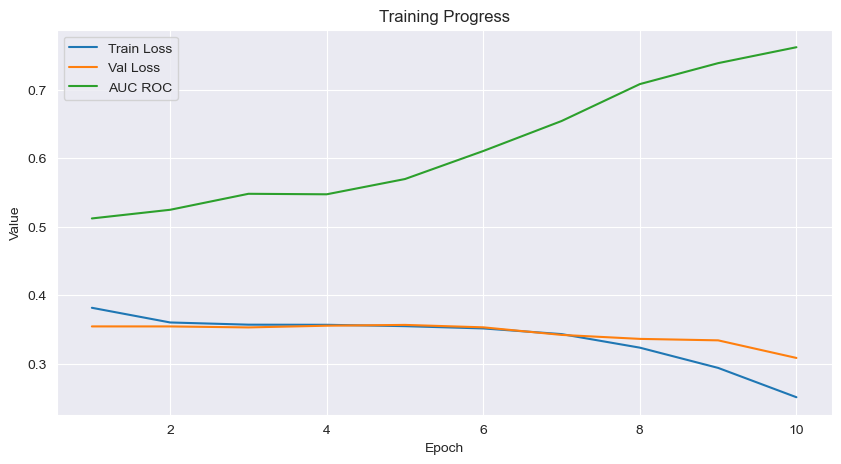

In [149]:
df_history = pd.DataFrame(history)
df_history['epoch'] = df_history.index + 1

plt.figure(figsize=(10,5))

sns.lineplot(x='epoch', y='train_loss', data=df_history, label='Train Loss')
sns.lineplot(x='epoch', y='val_loss', data=df_history, label='Val Loss')
sns.lineplot(x='epoch', y='auc', data=df_history, label='AUC ROC')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Progress')
plt.legend()
plt.show()

### 5. Предобученная модель ResNet18 / DenseNet

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("resnet18", pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 9)  
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 3
log_interval = 10

for epoch in range(epochs):
    # --- Обучение ---
    model.train()
    train_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images= images.to(device)
        labels = labels.to(device)
        labels_onehot = torch.zeros(labels.size(0), 9, device=device)
        labels_onehot.scatter_(1, labels.view(-1,1), 1)
        optimizer.zero_grad()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels_onehot)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (i + 1) % log_interval == 0:
            print(f'Epoch {epoch+1}, Step {i+1}/{len(train_loader)},'
                  f' Batch Loss: {loss.item():.4f}')

    # --- Валидация ---
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels_onehot = torch.zeros(labels.size(0), 9, device=device)
            labels_onehot.scatter_(1, labels.view(-1,1), 1)
            outputs = model(images).squeeze(1)
            preds = torch.sigmoid(outputs)
            all_labels.extend(labels_onehot.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
    
    auc = roc_auc_score(all_labels, all_preds, average='macro')
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {sum(train_losses)/len(train_losses):.4f} | Val AUC: {auc:.4f}")

Epoch 1, Step 10/131, Batch Loss: 0.3994
Epoch 1, Step 20/131, Batch Loss: 0.3509
Epoch 1, Step 30/131, Batch Loss: 0.3669
Epoch 1, Step 40/131, Batch Loss: 0.3422
Epoch 1, Step 50/131, Batch Loss: 0.3383
Epoch 1, Step 60/131, Batch Loss: 0.3319
Epoch 1, Step 70/131, Batch Loss: 0.3317
Epoch 1, Step 80/131, Batch Loss: 0.3189
Epoch 1, Step 90/131, Batch Loss: 0.3168
Epoch 1, Step 100/131, Batch Loss: 0.3129
Epoch 1, Step 110/131, Batch Loss: 0.2747
Epoch 1, Step 120/131, Batch Loss: 0.2976
Epoch 1, Step 130/131, Batch Loss: 0.2667
Epoch 1/3 | Train Loss: 0.3394 | Val AUC: 0.7188
Epoch 2, Step 10/131, Batch Loss: 0.2442
Epoch 2, Step 20/131, Batch Loss: 0.2506
Epoch 2, Step 30/131, Batch Loss: 0.2244
Epoch 2, Step 40/131, Batch Loss: 0.1839
Epoch 2, Step 50/131, Batch Loss: 0.1890
Epoch 2, Step 60/131, Batch Loss: 0.2392
Epoch 2, Step 70/131, Batch Loss: 0.2147
Epoch 2, Step 80/131, Batch Loss: 0.1952
Epoch 2, Step 90/131, Batch Loss: 0.1748
Epoch 2, Step 100/131, Batch Loss: 0.2045
Epo

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("densenet121", pretrained=True)
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.classifier = nn.Linear(model.classifier.in_features, 9)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 3
log_interval = 10

for epoch in range(epochs):
    # --- Обучение ---
    model.train()
    train_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        labels_onehot = torch.zeros(labels.size(0), 9, device=device)
        labels_onehot.scatter_(1, labels.view(-1,1), 1)
        optimizer.zero_grad()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels_onehot)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (i + 1) % log_interval == 0:
            print(f'Epoch {epoch+1}, Step {i+1}/{len(train_loader)},'
                  f' Batch Loss: {loss.item():.4f}')

    # --- Валидация ---
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels_onehot = torch.zeros(labels.size(0), 9, device=device)
            labels_onehot.scatter_(1, labels.view(-1,1), 1)
            outputs = model(images).squeeze(1)
            preds = torch.sigmoid(outputs)
            all_labels.extend(labels_onehot.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
    
    auc = roc_auc_score(all_labels, all_preds, average='macro')
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {sum(train_losses)/len(train_losses):.4f} | Val AUC: {auc:.4f}")

Epoch 1, Step 10/131, Batch Loss: 0.3710
Epoch 1, Step 20/131, Batch Loss: 0.3453
Epoch 1, Step 30/131, Batch Loss: 0.3097
Epoch 1, Step 40/131, Batch Loss: 0.2999
Epoch 1, Step 50/131, Batch Loss: 0.3006
Epoch 1, Step 60/131, Batch Loss: 0.2807
Epoch 1, Step 70/131, Batch Loss: 0.3015
Epoch 1, Step 80/131, Batch Loss: 0.2558
Epoch 1, Step 90/131, Batch Loss: 0.2220
Epoch 1, Step 100/131, Batch Loss: 0.2200
Epoch 1, Step 110/131, Batch Loss: 0.2100
Epoch 1, Step 120/131, Batch Loss: 0.2230
Epoch 1, Step 130/131, Batch Loss: 0.1972
Epoch 1/3 | Train Loss: 0.2908 | Val AUC: 0.8695
Epoch 2, Step 10/131, Batch Loss: 0.2009
Epoch 2, Step 20/131, Batch Loss: 0.1693
Epoch 2, Step 30/131, Batch Loss: 0.1761
Epoch 2, Step 40/131, Batch Loss: 0.1833
Epoch 2, Step 50/131, Batch Loss: 0.1517
Epoch 2, Step 60/131, Batch Loss: 0.1954
Epoch 2, Step 70/131, Batch Loss: 0.1795
Epoch 2, Step 80/131, Batch Loss: 0.2003
Epoch 2, Step 90/131, Batch Loss: 0.1502
Epoch 2, Step 100/131, Batch Loss: 0.1612
Epo

### 6. Аугментация изображений

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Аугментации для тренировочного набора
train_transform = A.Compose([
    A.Resize(128, 128),
    # A.HorizontalFlip(p=0.5),           # случайное отражение по горизонтали
    A.VerticalFlip(p=0.2),             # случайное отражение по вертикали
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),  # нормализация
    ToTensorV2()  # конвертируем в torch.Tensor
])

# Для валидации обычно без аугментаций, только resize и normalize
valid_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

class AlbumentationsDataset(Dataset):
    def __init__(self, df, transform=None, labels_idx=None):
        self.df = df
        self.transform = transform
        self.labels_idx_num = labels_idx
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f'data/Images/{row["img_IDS"]}.jpg'
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # один канал

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        label = self.labels_idx_num[row["Label"]]
        label = torch.tensor(label, dtype=torch.long)
        return image, label

labels_idx_num = {label: idx for idx, label in enumerate(labels['Label'].unique())}

train_dataset = AlbumentationsDataset(train_df, transform=train_transform, labels_idx=labels_idx_num)
valid_dataset = AlbumentationsDataset(valid_df, transform=valid_transform, labels_idx=labels_idx_num)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("resnet18", pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 9)  
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 3
log_interval = 10

for epoch in range(epochs):
    # --- Обучение ---
    model.train()
    train_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        labels_onehot = torch.zeros(labels.size(0), 9, device=device)
        labels_onehot.scatter_(1, labels.view(-1,1), 1)
        optimizer.zero_grad()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels_onehot)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (i + 1) % log_interval == 0:
            print(f'Epoch {epoch+1}, Step {i+1}/{len(train_loader)},'
                  f' Batch Loss: {loss.item():.4f}')

    # --- Валидация ---
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels_onehot = torch.zeros(labels.size(0), 9, device=device)
            labels_onehot.scatter_(1, labels.view(-1,1), 1)
            outputs = model(images).squeeze(1)
            preds = torch.sigmoid(outputs)
            all_labels.extend(labels_onehot.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
    
    auc = roc_auc_score(all_labels, all_preds, average='macro')
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {sum(train_losses)/len(train_losses):.4f} | Val AUC: {auc:.4f}")

Epoch 1, Step 10/131, Batch Loss: 0.4311
Epoch 1, Step 20/131, Batch Loss: 0.3648
Epoch 1, Step 30/131, Batch Loss: 0.3536
Epoch 1, Step 40/131, Batch Loss: 0.3604
Epoch 1, Step 50/131, Batch Loss: 0.3475
Epoch 1, Step 60/131, Batch Loss: 0.3411
Epoch 1, Step 70/131, Batch Loss: 0.3385
Epoch 1, Step 80/131, Batch Loss: 0.3339
Epoch 1, Step 90/131, Batch Loss: 0.3506
Epoch 1, Step 100/131, Batch Loss: 0.3513
Epoch 1, Step 110/131, Batch Loss: 0.3137
Epoch 1, Step 120/131, Batch Loss: 0.3116
Epoch 1, Step 130/131, Batch Loss: 0.2960
Epoch 1/3 | Train Loss: 0.3557 | Val AUC: 0.7523
Epoch 2, Step 10/131, Batch Loss: 0.3079
Epoch 2, Step 20/131, Batch Loss: 0.2809
Epoch 2, Step 30/131, Batch Loss: 0.2842
Epoch 2, Step 40/131, Batch Loss: 0.2819
Epoch 2, Step 50/131, Batch Loss: 0.2773
Epoch 2, Step 60/131, Batch Loss: 0.2720
Epoch 2, Step 70/131, Batch Loss: 0.2328
Epoch 2, Step 80/131, Batch Loss: 0.2459
Epoch 2, Step 90/131, Batch Loss: 0.2462
Epoch 2, Step 100/131, Batch Loss: 0.2480
Epo

### 7. MixUp и CutMix

In [10]:
mixup_fn = Mixup(
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
    prob=1.0,
    switch_prob=0.5,
    mode='elem',
    label_smoothing=0.1,
    num_classes=9
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("resnet18", pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 9)  
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 3
log_interval = 10

for epoch in range(epochs):
    # --- Обучение ---
    model.train()
    train_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # labels_onehot = torch.zeros(labels.size(0), 9, device=device)
        # labels_onehot.scatter_(1, labels.view(-1,1), 1)
        
        images, labels = mixup_fn(images, labels)
        
        optimizer.zero_grad()
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (i + 1) % log_interval == 0:
            print(f'Epoch {epoch+1}, Step {i+1}/{len(train_loader)},'
                  f' Batch Loss: {loss.item():.4f}')

    # --- Валидация ---
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels_onehot = torch.zeros(labels.size(0), 9, device=device)
            labels_onehot.scatter_(1, labels.view(-1,1), 1)
            outputs = model(images).squeeze(1)
            preds = torch.sigmoid(outputs)
            all_labels.extend(labels_onehot.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
    
    auc = roc_auc_score(all_labels, all_preds, average='macro')
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {sum(train_losses)/len(train_losses):.4f} | Val AUC: {auc:.4f}")

Epoch 1, Step 10/131, Batch Loss: 0.4153
Epoch 1, Step 20/131, Batch Loss: 0.3602
Epoch 1, Step 30/131, Batch Loss: 0.3618
Epoch 1, Step 40/131, Batch Loss: 0.3483
Epoch 1, Step 50/131, Batch Loss: 0.3638
Epoch 1, Step 60/131, Batch Loss: 0.3451
Epoch 1, Step 70/131, Batch Loss: 0.3534
Epoch 1, Step 80/131, Batch Loss: 0.3526
Epoch 1, Step 90/131, Batch Loss: 0.3561
Epoch 1, Step 100/131, Batch Loss: 0.3421
Epoch 1, Step 110/131, Batch Loss: 0.3410
Epoch 1, Step 120/131, Batch Loss: 0.3400
Epoch 1, Step 130/131, Batch Loss: 0.3372
Epoch 1/3 | Train Loss: 0.3642 | Val AUC: 0.6909
Epoch 2, Step 10/131, Batch Loss: 0.3291
Epoch 2, Step 20/131, Batch Loss: 0.3216
Epoch 2, Step 30/131, Batch Loss: 0.3320
Epoch 2, Step 40/131, Batch Loss: 0.3268
Epoch 2, Step 50/131, Batch Loss: 0.3276
Epoch 2, Step 60/131, Batch Loss: 0.3273
Epoch 2, Step 70/131, Batch Loss: 0.3036
Epoch 2, Step 80/131, Batch Loss: 0.3298
Epoch 2, Step 90/131, Batch Loss: 0.3134
Epoch 2, Step 100/131, Batch Loss: 0.3089
Epo

### 8. Бонус. Test-Time-Augmentation (TTA)

In [44]:
def center_crop(images, crop_size):
    _, _, H, W = images.shape
    top = (H - crop_size) // 2
    left = (W - crop_size) // 2
    return images[:, :, top:top+crop_size, left:left+crop_size]

model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels_onehot = torch.zeros(labels.size(0), 9, device=device)
        labels_onehot.scatter_(1, labels.view(-1,1), 1)
        
        outputs_original = model(images)
        preds_original = torch.sigmoid(outputs_original)
        
        images_crop = center_crop(images, crop_size=100)
        images_crop = F.interpolate(images_crop, size=(128,128), mode='bilinear', align_corners=False)
        outputs_crop = model(images_crop)
        preds_crop = torch.sigmoid(outputs_crop)
        
        preds = (preds_original + preds_crop) / 2
        
        all_labels.extend(labels_onehot.cpu().tolist())
        all_preds.extend(preds.cpu().tolist())

auc = roc_auc_score(all_labels, all_preds, average='macro')
print(f"Validation AUC with TTA: {auc:.4f}")

Validation AUC with TTA: 0.9196
